# Machine Learning Coursework Code 2021

Shang Li

21114121

# Data Exploration

## Read data

In [1]:
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

## ignore useless warnings
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_seq_items=8000
pd.options.display.max_rows = 8000

In [2]:
df = pd.read_csv('Coursework_1_data.csv')

## Information of the dataset

In [3]:
print('\nInformation of the dataset: \n')
print(df.info())

print('\nNumbers of the duplicates: ',len(df[df.duplicated()]) )


Information of the dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int6

## Get rid of duplicates

In [4]:
df1 = df.drop_duplicates() # Drop the duplicates and name it df1
df1.shape

(12205, 18)

## Correlation

<AxesSubplot:>

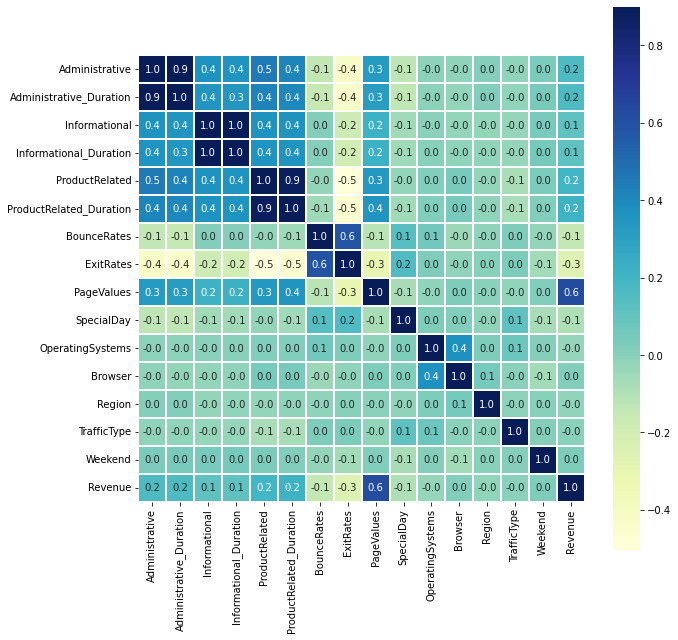

In [5]:
spearmanCorr = df1.corr(method = "spearman")
plt.figure(figsize=(10,10))
sns.heatmap(spearmanCorr, vmax=0.9, square=True, annot=True, linewidths=0.3, cmap="YlGnBu", fmt=".1f")

# Copy from CMT307Lab0Ex2.ipynb correlation check.

## Histogram

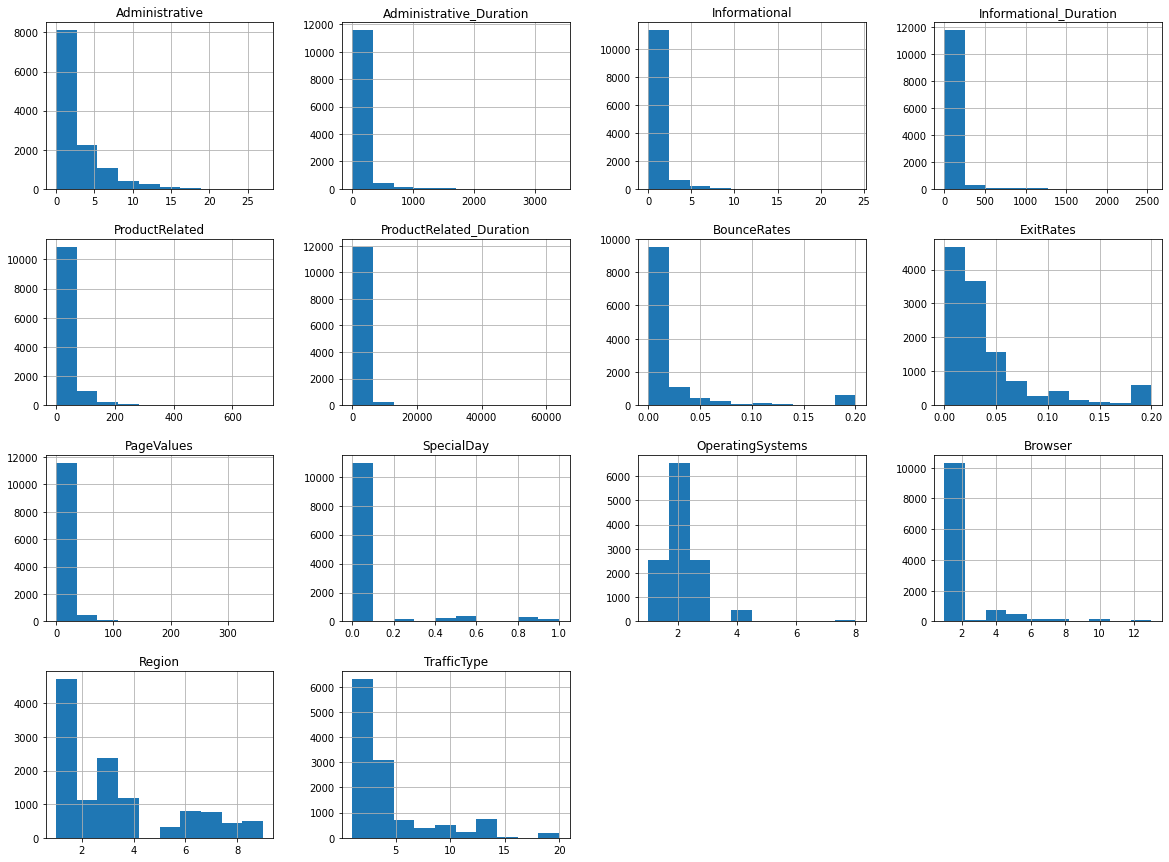

In [6]:
df1.iloc[:,0:-2].hist(figsize=(20,15))
plt.show()

# Distribution of each feature.

False    10297
True      1908
Name: Revenue, dtype: int64

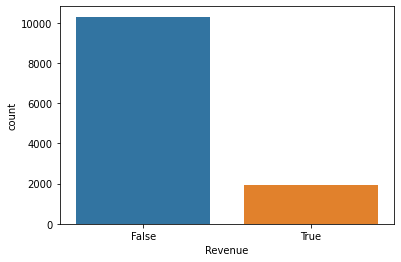

In [7]:
sns.countplot(x = df1["Revenue"])
df1.Revenue.value_counts()

# The data is imbalanced

# Data pre-processing

## Split data into training set and test set

In [8]:
df1_x = df1.iloc[:, 0:-1] # inpuut
df1_y = df1[['Revenue']] # output

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df1_x, df1_y, test_size=0.3, random_state=42)

## Checking feature importance & selection

In [10]:
# Since other categrical features are already encoded ordinally, I use OrdinalEncoder to encode rest two features (Month, VisitorType) as well.
# Just for feature selection purpose.

enc = OrdinalEncoder()
Month = X_train[['Month']]
VisitorType = X_train[['VisitorType']]
X_train['Month'] = enc.fit_transform(Month)
X_train['VisitorType'] = enc.fit_transform(VisitorType)

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_train, y_train)

for name, score in zip(X_train.columns, rnd_clf.feature_importances_):
    print(name, score)

Administrative 0.04138184505204122
Administrative_Duration 0.05846383436433469
Informational 0.015972914748203514
Informational_Duration 0.026161468456595977
ProductRelated 0.07363543584216879
ProductRelated_Duration 0.09003453231744246
BounceRates 0.058280280649103185
ExitRates 0.08297556577839
PageValues 0.38556722787403946
SpecialDay 0.0034823477915154584
Month 0.04246255864190714
OperatingSystems 0.01740364281783724
Browser 0.019379334855039513
Region 0.031153332659246562
TrafficType 0.03214418918142915
VisitorType 0.011042680098348086
Weekend 0.010458808872357454


In [11]:
# Select features which importance > 0.05

X_train = X_train[['PageValues','ProductRelated_Duration','ExitRates','ProductRelated','Administrative_Duration','BounceRates']]

## Oversampling

False    7181
True     7181
Name: Revenue, dtype: int64

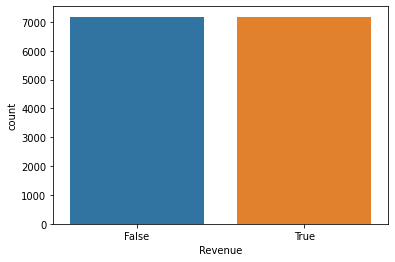

In [12]:
# Using SMOTE to oversample the training set

from imblearn.over_sampling import SMOTE

smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_resample(X_train, y_train)

sns.countplot(x = y_smo['Revenue'])
y_smo.Revenue.value_counts()

<AxesSubplot:>

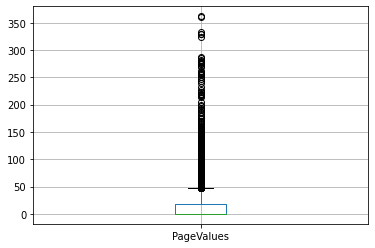

In [13]:
X_smo[['PageValues']].boxplot()

## Preprocessing Pipeline & ColumnTransformer

In [14]:
numeric_features = ['PageValues','ProductRelated_Duration','ExitRates','ProductRelated','Administrative_Duration','BounceRates']

numeric_transformer = Pipeline(
    [
     ('scaler',RobustScaler()) # Robust for outliers scaling.
    ]
)

preprocessor = ColumnTransformer(
    [
     ('numericals', numeric_transformer, numeric_features)
    ],
    remainder = 'drop'
)

# Model implementation

## Logistic Regression

In [15]:
log_clf = Pipeline(
    [
     ('preprocessing', preprocessor),
     ('classifier', LogisticRegression(C=1, random_state=42))
    ]
)

In [16]:
start = time.time()

log_clf.fit(X_smo, y_smo)

stop = time.time()
print(f"training time: {stop - start}s")

#https://stackoverflow.com/questions/22210768/getting-training-time-in-scikit

training time: 0.026999711990356445s


In [17]:
metrics = ['f1', 'roc_auc','accuracy']

for m in metrics:
  scores = cross_val_score(log_clf, X_smo, y_smo, cv=5, scoring= m)
  print(m, '%.2f' % scores.mean())

# cross validation

f1 0.82
roc_auc 0.90
accuracy 0.84


In [18]:
# LR gridsearch

# using scaled data to search the best parameters
X_smo_processed = preprocessor.fit_transform(X_smo)

# define search space
space = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

# defie the model
model = LogisticRegression(random_state=42)

# define search
search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=5)

# execute search
result = search.fit(X_smo_processed, y_smo)

# summarize result
print('Best Score: %s' % result.best_score_)
result.best_estimator_

Best Score: 0.8246051268199921


LogisticRegression(C=1, random_state=42)

## SVM

In [19]:
#linear
linear_svm_clf = LinearSVC()
#poly
poly_kernel_svm_clf = SVC(kernel="poly")
#rbf
rbf_kernel_svm_clf = SVC(kernel='rbf')

In [20]:
for clf in (linear_svm_clf, poly_kernel_svm_clf, rbf_kernel_svm_clf):
  scores = cross_val_score(clf, X_smo_processed, y_smo, cv=5, scoring= 'f1')
  print(clf.__class__.__name__, scores.mean())

LinearSVC 0.8064620491585387
SVC 0.5674188562589606
SVC 0.8444289986075513


In [21]:
# As the result above, the rbf kernel SVM has the highest f1-score, so I base on it to build the SVM model.

rbf_kernel_svm_clf = Pipeline(
    [
     ('preprocessing', preprocessor),
     ('classifier', SVC(kernel='rbf', C=10, gamma=5, random_state=42))
    ]
)

In [22]:
start = time.time()

rbf_kernel_svm_clf.fit(X_smo, y_smo)

stop = time.time()
print(f"training time: {stop - start}s")

training time: 11.75930118560791s


In [23]:
metrics = ['f1', 'roc_auc','accuracy']

for m in metrics:
  scores = cross_val_score(rbf_kernel_svm_clf, X_smo, y_smo, cv=5, scoring= m)
  print(m, '%.2f' % scores.mean())


f1 0.89
roc_auc 0.95
accuracy 0.89


In [24]:
# SVC gridsearch

# define search space
space = {'gamma':[0.1, 1, 5], 'C':[0.1, 1, 10, 100, 1000]}   

# define the model
model = SVC(kernel="rbf",random_state=42)

# define search
search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=5)

# execute search
result = search.fit(X_smo_processed, y_smo)

# summarize result
print('Best Score: %s' % result.best_score_)
result.best_estimator_

Best Score: 0.8946241443655396


SVC(C=10, gamma=5, random_state=42)

## Decision Tree

In [25]:
tree_clf = Pipeline(
    [
     ('preprocessing', preprocessor),
     ('classifier', DecisionTreeClassifier(max_depth=11, max_leaf_nodes=30, random_state=42))
    ]
)

In [26]:
start = time.time()

tree_clf.fit(X_smo, y_smo)

stop = time.time()
print(f"training time: {stop - start}s")

training time: 0.04199957847595215s


In [27]:
metrics = ['f1', 'roc_auc','accuracy']

for m in metrics:
  scores = cross_val_score(tree_clf, X_smo, y_smo, cv=5, scoring= m)
  print(m, '%.2f' % scores.mean())


f1 0.89
roc_auc 0.93
accuracy 0.89


In [28]:
# Decision Tree gridsearch

# define search space
space = dict(
         max_depth = (1, 11), 
         min_samples_split = (2, 15), 
         min_samples_leaf = (1,10),
         max_leaf_nodes = (1, 30),
         )

# defie the model
model = DecisionTreeClassifier(random_state=42)

# define search
search = GridSearchCV(model, space, scoring='f1', n_jobs=-1, cv=5)

# execute search
result = search.fit(X_smo_processed, y_smo)

# summarize result
print('Best Score: %s' % result.best_score_)
result.best_estimator_

Best Score: 0.8944820512466523


DecisionTreeClassifier(max_depth=11, max_leaf_nodes=30, random_state=42)

# Performence Evaluation

In [29]:
log_clf_pred = log_clf.predict(X_test)
svm_clf_pred = rbf_kernel_svm_clf.predict(X_test)
tree_clf_pred = tree_clf.predict(X_test)

In [30]:
clf_name = ['LR', 'SVM', 'DT']
clf_pred = [log_clf_pred, svm_clf_pred, tree_clf_pred]

In [31]:
for name, y_pred in zip(clf_name, clf_pred):
  print(name, classification_report(y_test, y_pred))
  print('AUC score', '%.2f' % roc_auc_score(y_test, y_pred))
  print('\n')

LR               precision    recall  f1-score   support

       False       0.95      0.90      0.93      3116
        True       0.57      0.73      0.64       546

    accuracy                           0.88      3662
   macro avg       0.76      0.82      0.78      3662
weighted avg       0.89      0.88      0.88      3662

AUC score 0.82


SVM               precision    recall  f1-score   support

       False       0.93      0.90      0.91      3116
        True       0.51      0.59      0.55       546

    accuracy                           0.86      3662
   macro avg       0.72      0.75      0.73      3662
weighted avg       0.86      0.86      0.86      3662

AUC score 0.75


DT               precision    recall  f1-score   support

       False       0.96      0.88      0.92      3116
        True       0.54      0.81      0.65       546

    accuracy                           0.87      3662
   macro avg       0.75      0.85      0.79      3662
weighted avg       0.90      0

# Result analysis and discussion (same content in the report)

array([[<AxesSubplot:xlabel='BounceRates', ylabel='BounceRates'>,
        <AxesSubplot:xlabel='ExitRates', ylabel='BounceRates'>,
        <AxesSubplot:xlabel='PageValues', ylabel='BounceRates'>],
       [<AxesSubplot:xlabel='BounceRates', ylabel='ExitRates'>,
        <AxesSubplot:xlabel='ExitRates', ylabel='ExitRates'>,
        <AxesSubplot:xlabel='PageValues', ylabel='ExitRates'>],
       [<AxesSubplot:xlabel='BounceRates', ylabel='PageValues'>,
        <AxesSubplot:xlabel='ExitRates', ylabel='PageValues'>,
        <AxesSubplot:xlabel='PageValues', ylabel='PageValues'>]],
      dtype=object)

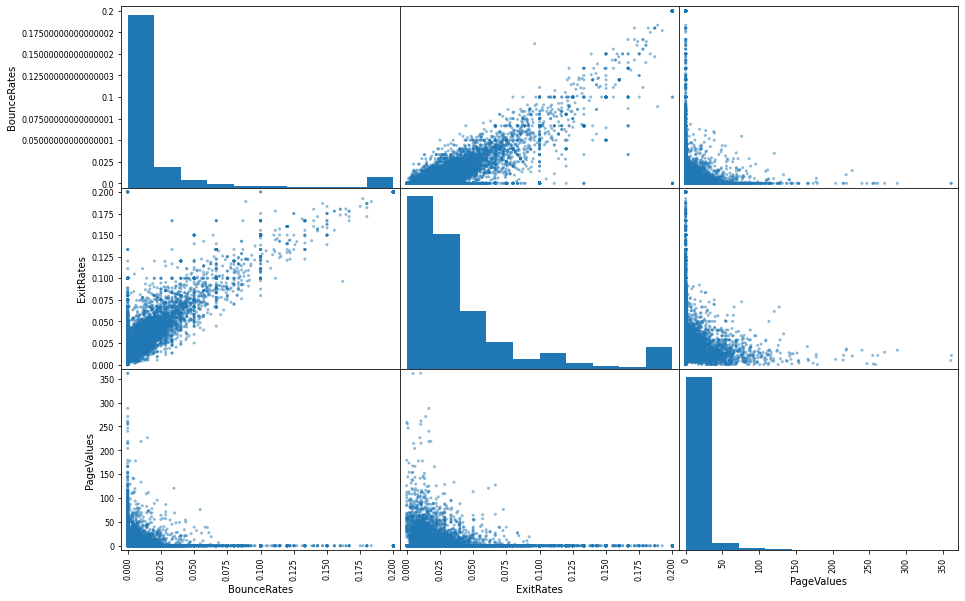

In [32]:
from pandas.plotting import scatter_matrix
scatter_matrix(df1[['BounceRates','ExitRates','PageValues']], figsize=(15, 10))